# Time Analysis Plot: Density

**Primary Author**

Nuoyi Wang


**Description:**

This notebook contains the basic time analysis of visitation to food-related POI locations and plot the following metrics. 


**Inputs:**

data/weekly_and_core_with_area.csv


**Outputs/Plots of Metrics:**

Overall visit density by borough

Visit density in each borough by category

Median of visit density in each borough by category

In [1]:
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
weekly_and_core = dd.read_csv("data/weekly_and_core_with_area.csv", dtype={'brands': 'object',
                                                            'distance_from_home': 'float64',
                                                           'area_square_feet': 'float64',
                                                            'opened_on': 'object',
                                                            'parent_placekey': 'object',
                                                            'safegraph_brand_ids': 'object',
                                                            'tracking_opened_since': 'object',
                                                            'category_tags': 'object',
                                                                        'poi_cbg':'object'}) # dtype to avoid error using dask

In [3]:
weekly_and_core.head()

placekey parent_placekey safegraph_brand_ids  \
0  222-222@627-s94-nwk             NaN                 NaN   
1  222-222@627-s94-nwk             NaN                 NaN   
2  222-222@627-s94-nwk             NaN                 NaN   
3  222-222@627-s94-nwk             NaN                 NaN   
4  222-222@627-s94-nwk             NaN                 NaN   

            date_range_start             date_range_end  raw_visit_counts  \
0  2020-12-21 05:00:00+00:00  2020-12-28T00:00:00-05:00                39   
1  2021-01-11 05:00:00+00:00  2021-01-18T00:00:00-05:00                41   
2  2021-01-18 05:00:00+00:00  2021-01-25T00:00:00-05:00                39   
3  2021-01-25 05:00:00+00:00  2021-02-01T00:00:00-05:00                45   
4  2019-01-07 05:00:00+00:00  2019-01-14T00:00:00-05:00                75   

   raw_visitor_counts       visits_by_day  \
0                  24     [7,9,6,5,3,5,4]   
1                  27    [3,5,7,4,6,13,3]   
2                  21     [3,6,7,6,7,8,2]   
3                  24     [6,5,7,8,5,6,8]   
4                  40  [4,6,14,24,8,10,9]   

                                 visits_by_each_hour       poi_cbg  ...  \
0  [0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...  360470395002  ...   
1  [0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...  360470395002  ...   
2  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1...  360470395002  ...   
3  [0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,1,0,1,0,0,0...  360470395002  ...   
4  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0...  360470395002  ...   

                                          open_hours category_tags opened_on  \
0  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...           NaN       NaN   
1  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...           NaN       NaN   
2  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...           NaN       NaN   
3  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...           NaN       NaN   
4  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...           NaN       NaN   

   closed_on  tracking_opened_since tracking_closed_since  \
0        NaN                    NaN               2019-07   
1        NaN                    NaN               2019-07   
2        NaN                    NaN               2019-07   
3        NaN                    NaN               2019-07   
4        NaN                    NaN               2019-07   

                                 category        date  \
0  Supermarkets and Specialty Food Stores  2020-12-21   
1  Supermarkets and Specialty Food Stores  2021-01-11   
2  Supermarkets and Specialty Food Stores  2021-01-18   
3  Supermarkets and Specialty Food Stores  2021-01-25   
4  Supermarkets and Specialty Food Stores  2019-01-07   

                    safegraph_place_id area_square_feet  
0  sg:bbe025bf97774f46b165507367517013           3177.0  
1  sg:bbe025bf97774f46b165507367517013           3177.0  
2  sg:bbe025bf97774f46b165507367517013           3177.0  
3  sg:bbe025bf97774f46b165507367517013           3177.0  
4  sg:bbe025bf97774f46b165507367517013           3177.0  

[5 rows x 40 columns]

In [3]:
weekly_and_core.columns

Index(['placekey', 'parent_placekey', 'safegraph_brand_ids',
       'date_range_start', 'date_range_end', 'raw_visit_counts',
       'raw_visitor_counts', 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_week_brand', 'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
       'city', 'region', 'postal_code', 'iso_country_code', 'open_hours',
       'category_tags', 'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'category', 'date', 'safegraph_place_id',
       'area_square_feet'],
      dtype='object')

In [3]:
weekly_and_core[['placekey', 'parent_placekey', 'safegraph_brand_ids',
       'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
      'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
       'city', 'region', 'postal_code', 'iso_country_code', 'open_hours',
        'safegraph_place_id',
       'area_square_feet']].head(2)

placekey parent_placekey safegraph_brand_ids       poi_cbg  \
0  222-222@627-s94-nwk             NaN                 NaN  360470395002   
1  222-222@627-s94-nwk             NaN                 NaN  360470395002   

                                   visitor_home_cbgs  \
0  {"420950106007":5,"360470399002":4,"3604711420...   
1  {"360470397003":8,"360810142011":4,"3604703950...   

                                visitor_daytime_cbgs  \
0  {"360470411002":5,"360470385001":4,"3604703950...   
1  {"360470395002":4,"360810008002":4,"3608110290...   

  visitor_country_of_origin  distance_from_home  median_dwell   location_name  \
0                 {"US":28}              1911.0          49.0  Broadway Meats   
1                 {"US":25}              5109.0          34.0  Broadway Meats   

   ...   latitude  longitude street_address      city  region  postal_code  \
0  ...  40.691436 -73.924891  1259 Broadway  Brooklyn      NY        11221   
1  ...  40.691436 -73.924891  1259 Broadway  Brooklyn      NY        11221   

  iso_country_code                                         open_hours  \
0               US  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...   
1               US  { "Mon": [["8:00", "19:00"]], "Tue": [["8:00",...   

                    safegraph_place_id  area_square_feet  
0  sg:bbe025bf97774f46b165507367517013            3177.0  
1  sg:bbe025bf97774f46b165507367517013            3177.0  

[2 rows x 24 columns]

In [4]:
weekly_sub = weekly_and_core[['placekey', 'date_range_start', 'raw_visit_counts', 'raw_visitor_counts', 
                 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
                'visitor_home_cbgs', 'visitor_daytime_cbgs', 'distance_from_home', 'median_dwell',
                   'bucketed_dwell_times','city','postal_code','top_category','sub_category', 'category','area_square_feet']].compute() # compute() tranform dask dataframe to pandas dataframe

In [5]:
weekly_sub['date_range_start'] = pd.to_datetime(weekly_sub['date_range_start'], infer_datetime_format=True, utc=True)
weekly_sub['date'] = weekly_sub['date_range_start'].dt.date
weekly_sub['density_visitors']=weekly_sub['raw_visitor_counts']/weekly_sub['area_square_feet']
weekly_sub['density_visits']=weekly_sub['raw_visit_counts']/weekly_sub['area_square_feet']

In [8]:
weekly_sub.head(2)

placekey          date_range_start  raw_visit_counts  \
0  222-222@627-s94-nwk 2020-12-21 05:00:00+00:00                39   
1  222-222@627-s94-nwk 2021-01-11 05:00:00+00:00                41   

   raw_visitor_counts     visits_by_day  \
0                  24   [7,9,6,5,3,5,4]   
1                  27  [3,5,7,4,6,13,3]   

                                 visits_by_each_hour       poi_cbg  \
0  [0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...  360470395002   
1  [0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...  360470395002   

                                   visitor_home_cbgs  \
0  {"420950106007":5,"360470399002":4,"3604711420...   
1  {"360470397003":8,"360810142011":4,"3604703950...   

                                visitor_daytime_cbgs  distance_from_home  ...  \
0  {"360470411002":5,"360470385001":4,"3604703950...              1911.0  ...   
1  {"360470395002":4,"360810008002":4,"3608110290...              5109.0  ...   

       city postal_code           top_category  sub_category  \
0  Brooklyn       11221  Specialty Food Stores  Meat Markets   
1  Brooklyn       11221  Specialty Food Stores  Meat Markets   

                                 category area_square_feet        date  \
0  Supermarkets and Specialty Food Stores           3177.0  2020-12-21   
1  Supermarkets and Specialty Food Stores           3177.0  2021-01-11   

   density_visitors density_visits  month  
0          0.007554       0.012276     12  
1          0.008499       0.012905      1  

[2 rows x 22 columns]

In [8]:
# add borough

weekly_sub['borough']=''
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10001)&(weekly_sub['postal_code']<=10286)]='Manhattan'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10301)&(weekly_sub['postal_code']<=10314)]='Staten Island'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10451)&(weekly_sub['postal_code']<=10499)]='Bronx'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=11200)&(weekly_sub['postal_code']<=11256)]='Brooklyn'
weekly_sub['borough'].iloc[((weekly_sub['postal_code']>=11001)&(weekly_sub['postal_code']<=11106))|((weekly_sub['postal_code']>=11354)&(weekly_sub['postal_code']<=11697))]='Queens'

In [9]:
weekly_sub=weekly_sub[(weekly_sub.borough == 'Manhattan')|(weekly_sub.borough=='Brooklyn')|(weekly_sub.borough=='Queens')|(weekly_sub.borough=='Bronx')|(weekly_sub.borough=='Staten Island')]

In [11]:
weekly_sub.head()

placekey          date_range_start  raw_visit_counts  \
0  222-222@627-s94-nwk 2020-12-21 05:00:00+00:00                39   
1  222-222@627-s94-nwk 2021-01-11 05:00:00+00:00                41   
2  222-222@627-s94-nwk 2021-01-18 05:00:00+00:00                39   
3  222-222@627-s94-nwk 2021-01-25 05:00:00+00:00                45   
4  222-222@627-s94-nwk 2019-01-07 05:00:00+00:00                75   

   raw_visitor_counts       visits_by_day  \
0                  24     [7,9,6,5,3,5,4]   
1                  27    [3,5,7,4,6,13,3]   
2                  21     [3,6,7,6,7,8,2]   
3                  24     [6,5,7,8,5,6,8]   
4                  40  [4,6,14,24,8,10,9]   

                                 visits_by_each_hour       poi_cbg  \
0  [0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...  360470395002   
1  [0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...  360470395002   
2  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1...  360470395002   
3  [0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,1,0,1,0,0,0...  360470395002   
4  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0...  360470395002   

                                   visitor_home_cbgs  \
0  {"420950106007":5,"360470399002":4,"3604711420...   
1  {"360470397003":8,"360810142011":4,"3604703950...   
2  {"360470377002":4,"360470251001":4,"3604703710...   
3  {"360470226002":5,"360470437002":4,"3604703650...   
4  {"360470293002":5,"360470395002":4,"3604704170...   

                                visitor_daytime_cbgs  distance_from_home  ...  \
0  {"360470411002":5,"360470385001":4,"3604703950...              1911.0  ...   
1  {"360470395002":4,"360810008002":4,"3608110290...              5109.0  ...   
2  {"360470363002":4,"360470573001":4,"5165001140...              4406.0  ...   
3  {"360470395002":4,"360850138002":4,"3604704370...              5607.0  ...   
4  {"360470369004":4,"360470924001":4,"3604708020...              2171.0  ...   

   postal_code           top_category  sub_category  \
0        11221  Specialty Food Stores  Meat Markets   
1        11221  Specialty Food Stores  Meat Markets   
2        11221  Specialty Food Stores  Meat Markets   
3        11221  Specialty Food Stores  Meat Markets   
4        11221  Specialty Food Stores  Meat Markets   

                                 category area_square_feet        date  \
0  Supermarkets and Specialty Food Stores           3177.0  2020-12-21   
1  Supermarkets and Specialty Food Stores           3177.0  2021-01-11   
2  Supermarkets and Specialty Food Stores           3177.0  2021-01-18   
3  Supermarkets and Specialty Food Stores           3177.0  2021-01-25   
4  Supermarkets and Specialty Food Stores           3177.0  2019-01-07   

  density_visitors  density_visits month   borough  
0         0.007554        0.012276    12  Brooklyn  
1         0.008499        0.012905     1  Brooklyn  
2         0.006610        0.012276     1  Brooklyn  
3         0.007554        0.014164     1  Brooklyn  
4         0.012590        0.023607     1  Brooklyn  

[5 rows x 23 columns]

### Manhattan

In [13]:
weekly_Manhattan=weekly_sub[weekly_sub['borough']=='Manhattan']
weekly_ctg_Manhattan = weekly_Manhattan.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_ctg_Manhattan.head(20)

raw_visit_counts  \
category                            date                           
Community and Special Food Services 2018-12-31             15431   
                                    2019-01-07             15828   
                                    2019-01-14             10122   
                                    2019-01-21              9209   
                                    2019-01-28              9843   
                                    2019-02-04              9910   
                                    2019-02-11             10439   
                                    2019-02-18              9646   
                                    2019-02-25              9988   
                                    2019-03-04             10136   
                                    2019-03-11             10883   
                                    2019-03-18             11071   
                                    2019-03-25             11571   
                                    2019-04-01             11385   
                                    2019-04-08             11722   
                                    2019-04-15             11386   
                                    2019-04-22             10470   
                                    2019-04-29             10849   
                                    2019-05-06             11235   
                                    2019-05-13             11404   

                                                raw_visitor_counts  \
category                            date                             
Community and Special Food Services 2018-12-31                6214   
                                    2019-01-07                6949   
                                    2019-01-14                7009   
                                    2019-01-21                6556   
                                    2019-01-28                6945   
                                    2019-02-04                7005   
                                    2019-02-11                7047   
                                    2019-02-18                6571   
                                    2019-02-25                6727   
                                    2019-03-04                6759   
                                    2019-03-11                7461   
                                    2019-03-18                7557   
                                    2019-03-25                7917   
                                    2019-04-01                7777   
                                    2019-04-08                8105   
                                    2019-04-15                8041   
                                    2019-04-22                7416   
                                    2019-04-29                7729   
                                    2019-05-06                7818   
                                    2019-05-13                7846   

                                                distance_from_home  \
category                            date                             
Community and Special Food Services 2018-12-31        24494.854369   
                                    2019-01-07        25963.377358   
                                    2019-01-14        15037.443396   
                                    2019-01-21        13270.156863   
                                    2019-01-28        13755.673267   
                                    2019-02-04        12493.048544   
                                    2019-02-11        24784.654206   
                                    2019-02-18        14450.392157   
                                    2019-02-25        15883.245283   
                                    2019-03-04        29563.644860   
                                    2019-03-11        28170.323810   
                                    2019-03-18        37713.057143   
                              

In [14]:
weekly_ctg_Manhattan['density_boro']=weekly_ctg_Manhattan['raw_visit_counts']/weekly_ctg_Manhattan['area_square_feet']

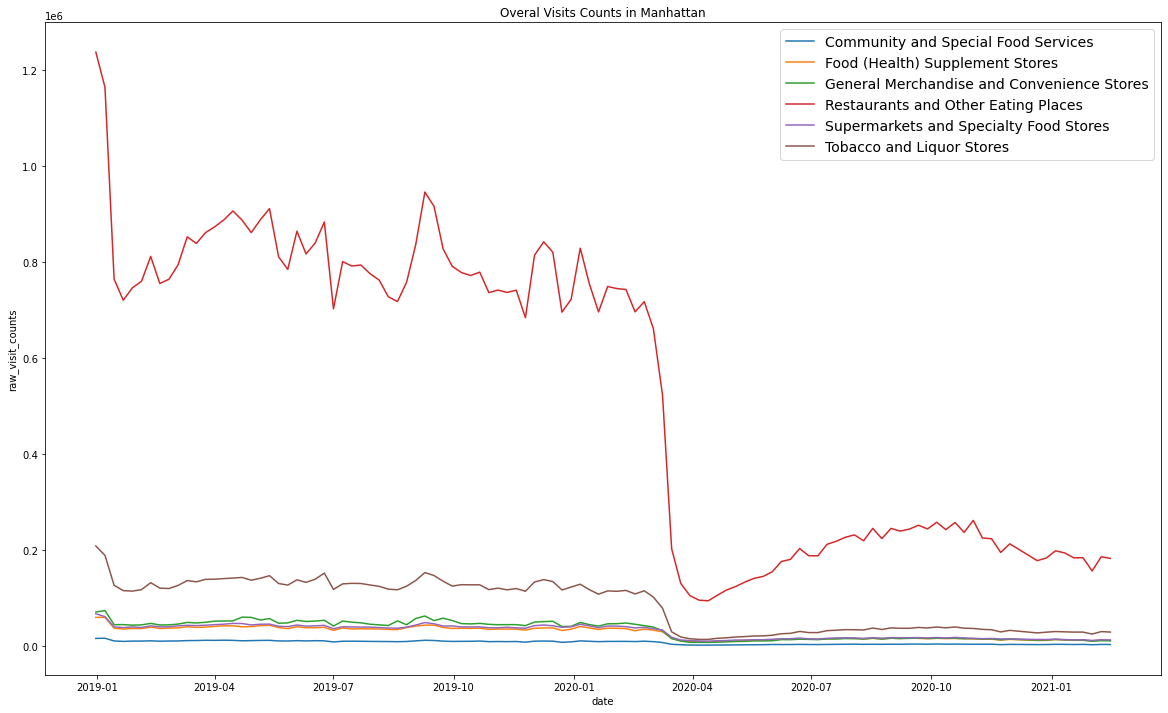

In [15]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Manhattan, x="date", y="raw_visit_counts", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts in Manhattan")
plt.show()

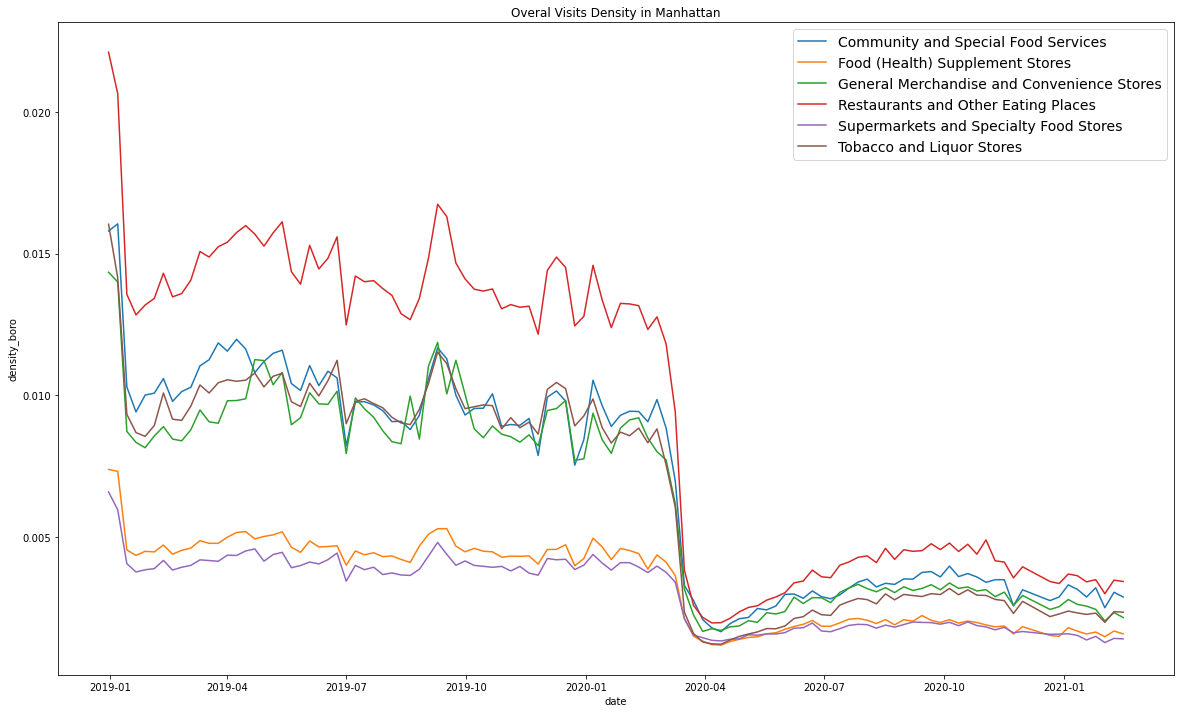

In [16]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Manhattan, x="date", y="density_boro", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Density in Manhattan")
plt.show()

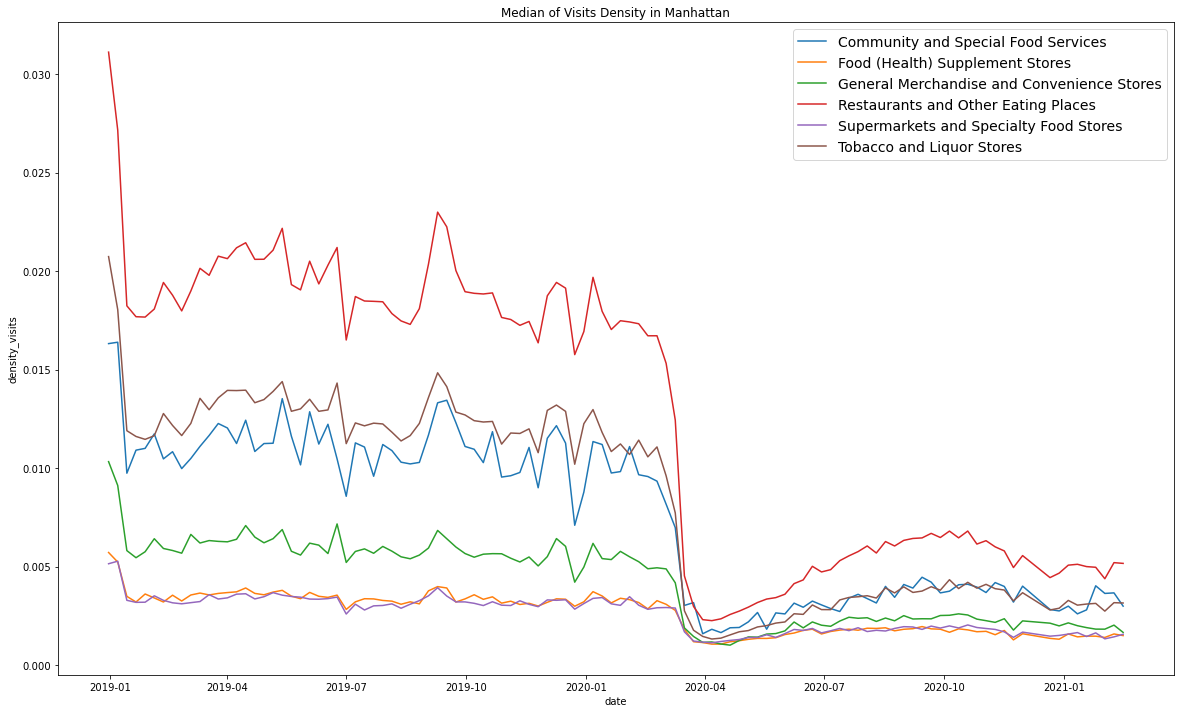

In [17]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Manhattan, x="date", y="density_visits", hue="category")
plt.legend(fontsize='14')
plt.title("Median of Visits Density in Manhattan")
plt.show()

### Brooklyn

In [18]:
weekly_Brooklyn=weekly_sub[weekly_sub['borough']=='Brooklyn']
weekly_ctg_Brooklyn = weekly_Brooklyn.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_ctg_Brooklyn['density_boro']=weekly_ctg_Brooklyn['raw_visit_counts']/weekly_ctg_Brooklyn['area_square_feet']

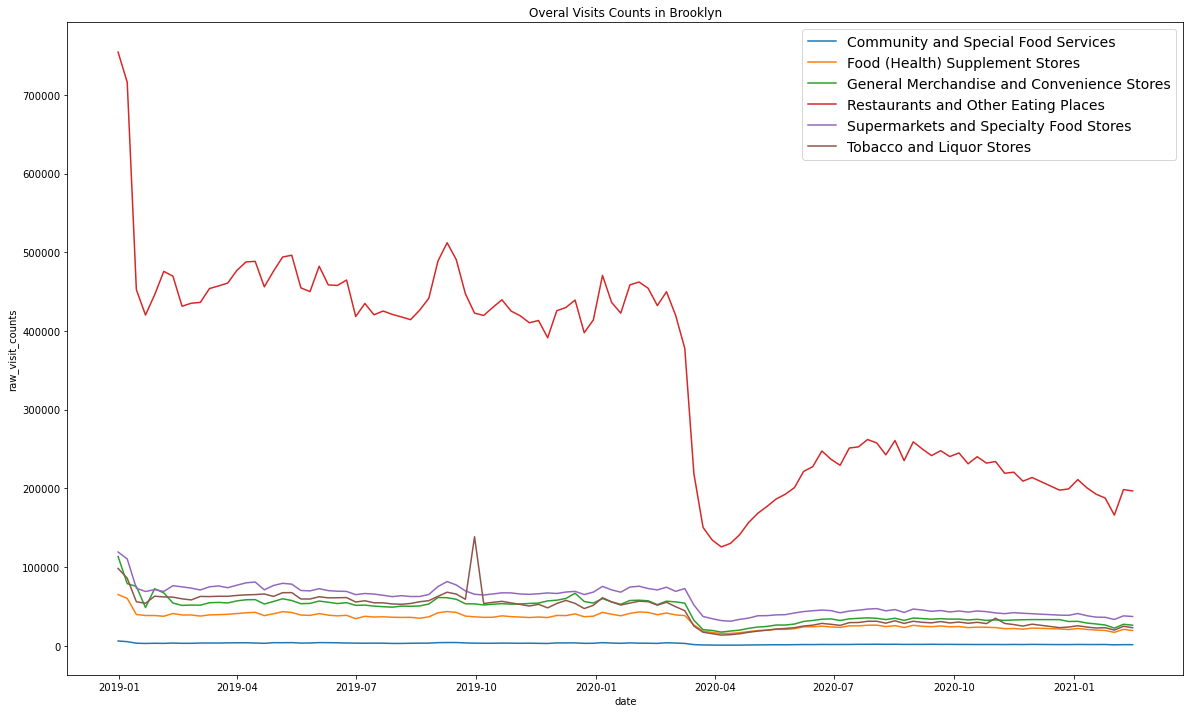

In [60]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Brooklyn, x="date", y="raw_visit_counts", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts in Brooklyn")
plt.show()

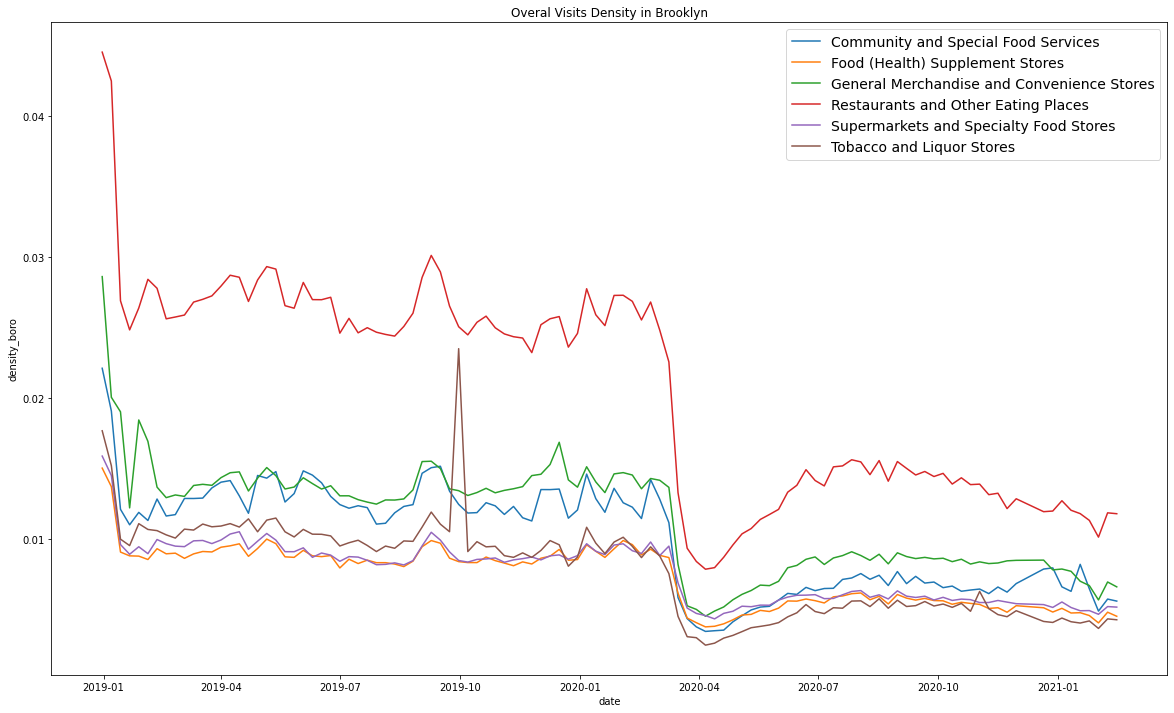

In [61]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Brooklyn, x="date", y="density_boro", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Density in Brooklyn")
plt.show()

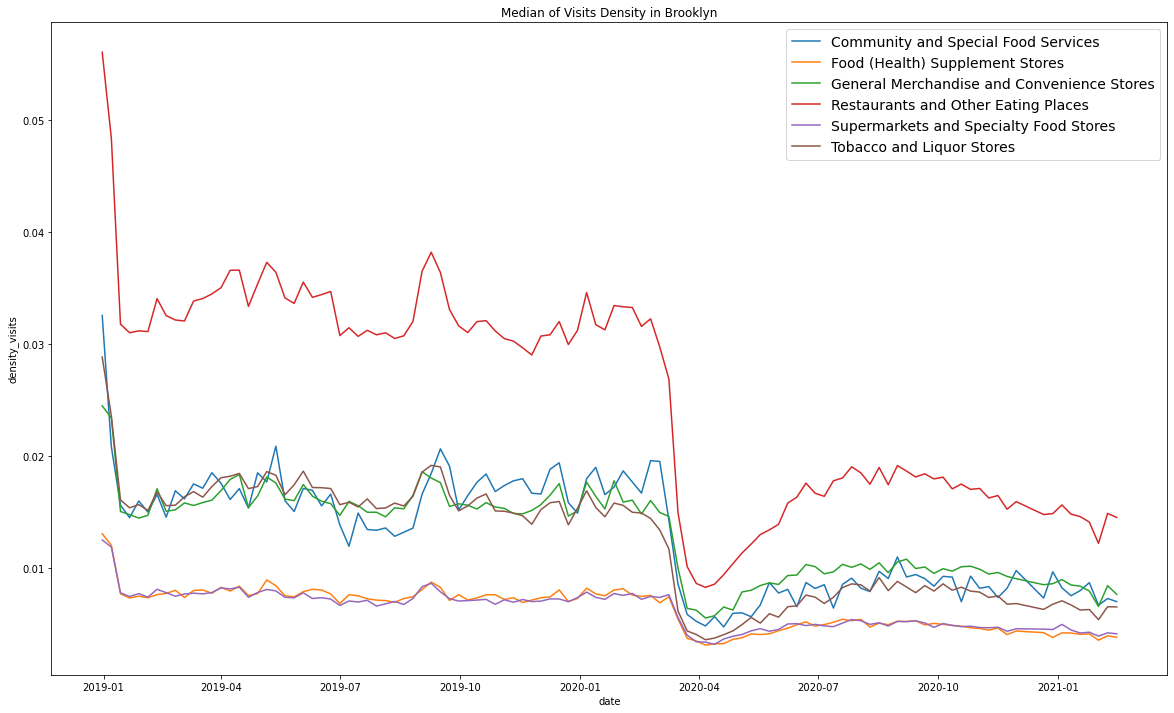

In [62]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Brooklyn, x="date", y="density_visits", hue="category")
plt.legend(fontsize='14')
plt.title("Median of Visits Density in Brooklyn")
plt.show()

### Bronx

In [22]:
weekly_Bronx=weekly_sub[weekly_sub['borough']=='Bronx']
weekly_ctg_Bronx = weekly_Bronx.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_ctg_Bronx['density_boro']=weekly_ctg_Bronx['raw_visit_counts']/weekly_ctg_Brooklyn['area_square_feet']

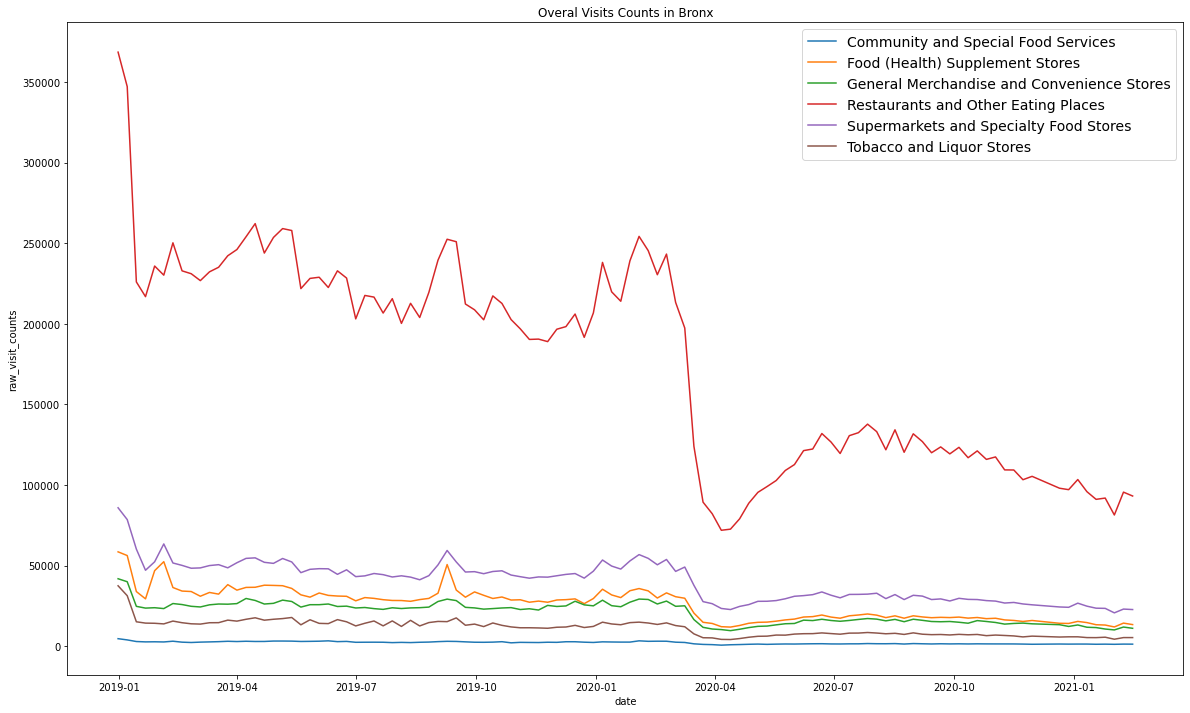

In [23]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Bronx, x="date", y="raw_visit_counts", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts in Bronx")
plt.show()

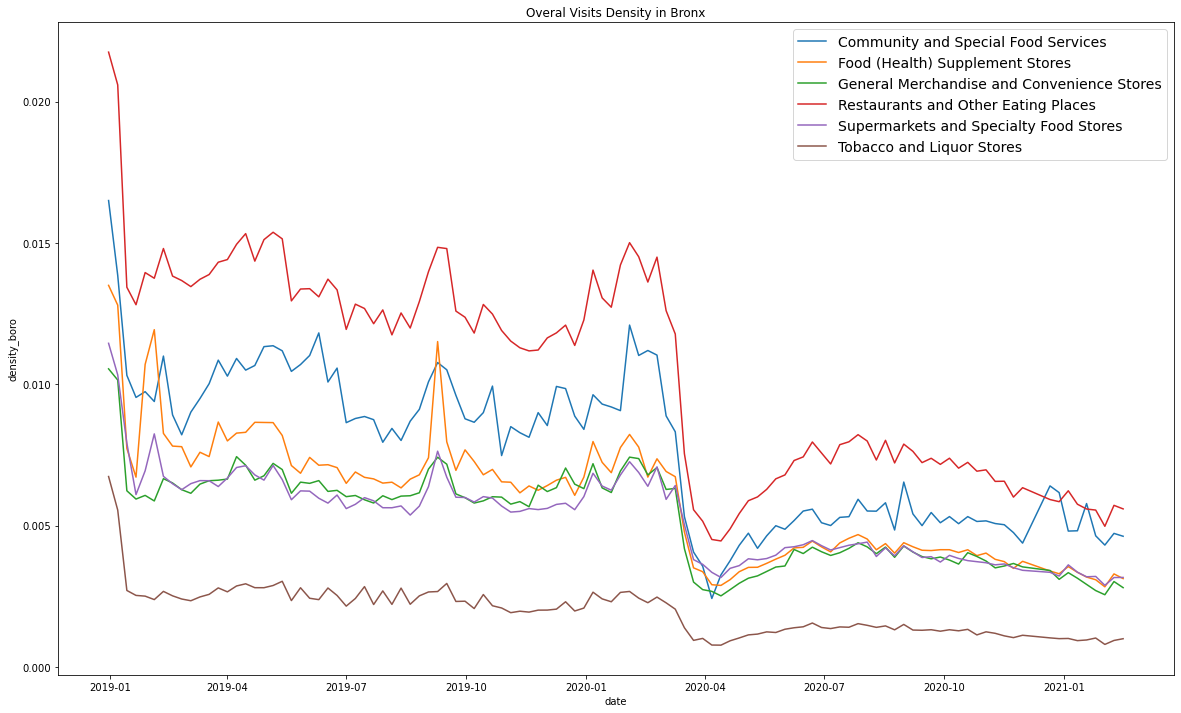

In [24]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Bronx, x="date", y="density_boro", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Density in Bronx")
plt.show()

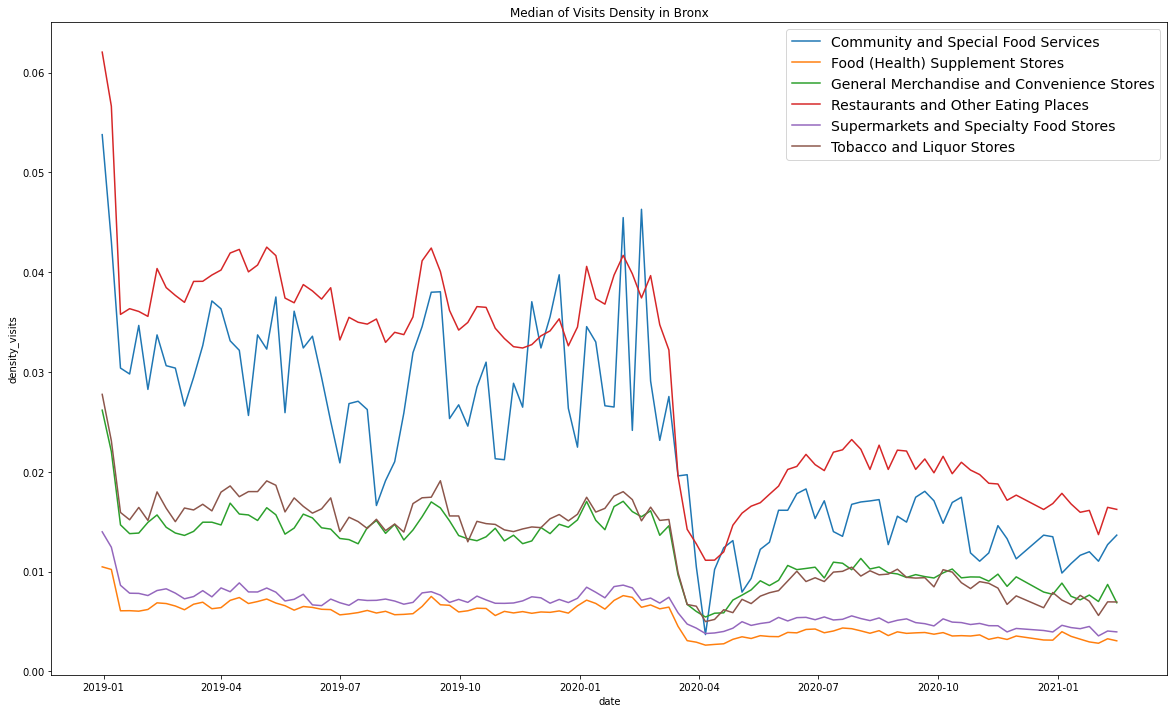

In [25]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Bronx, x="date", y="density_visits", hue="category")
plt.legend(fontsize='14')
plt.title("Median of Visits Density in Bronx")
plt.show()

### Queens

In [26]:
weekly_Queens=weekly_sub[weekly_sub['borough']=='Queens']
weekly_ctg_Queens = weekly_Queens.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_ctg_Queens['density_boro']=weekly_ctg_Queens['raw_visit_counts']/weekly_ctg_Brooklyn['area_square_feet']

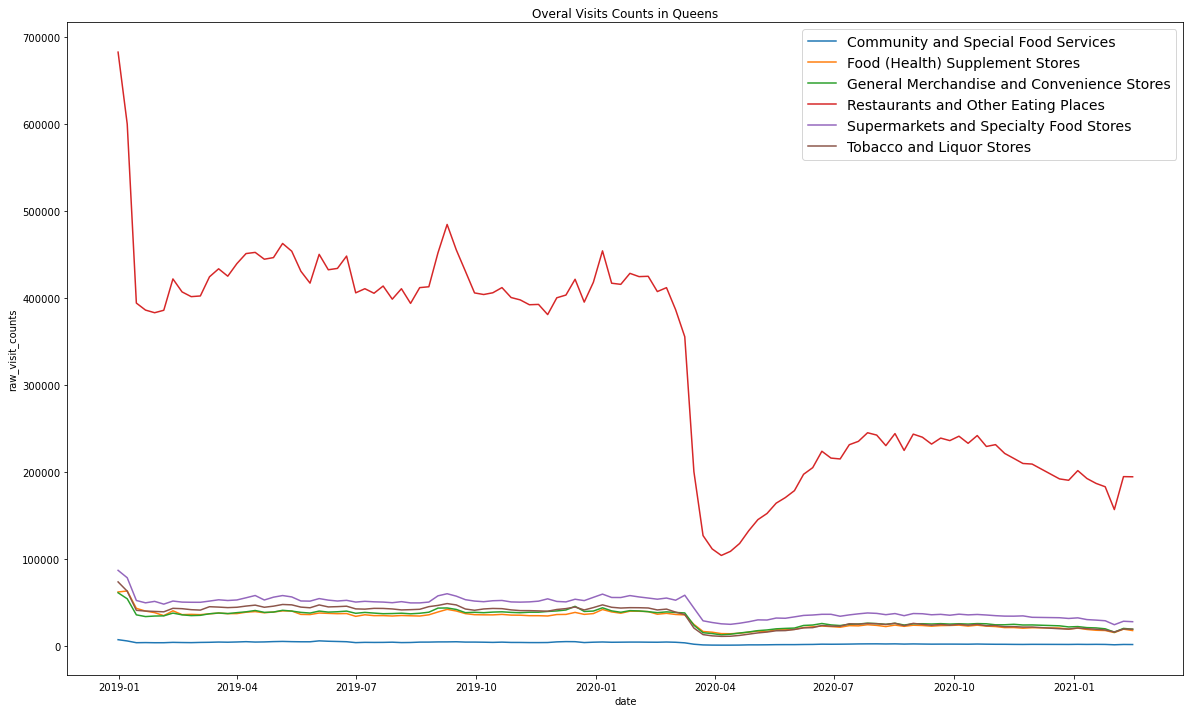

In [27]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Queens, x="date", y="raw_visit_counts", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts in Queens")
plt.show()

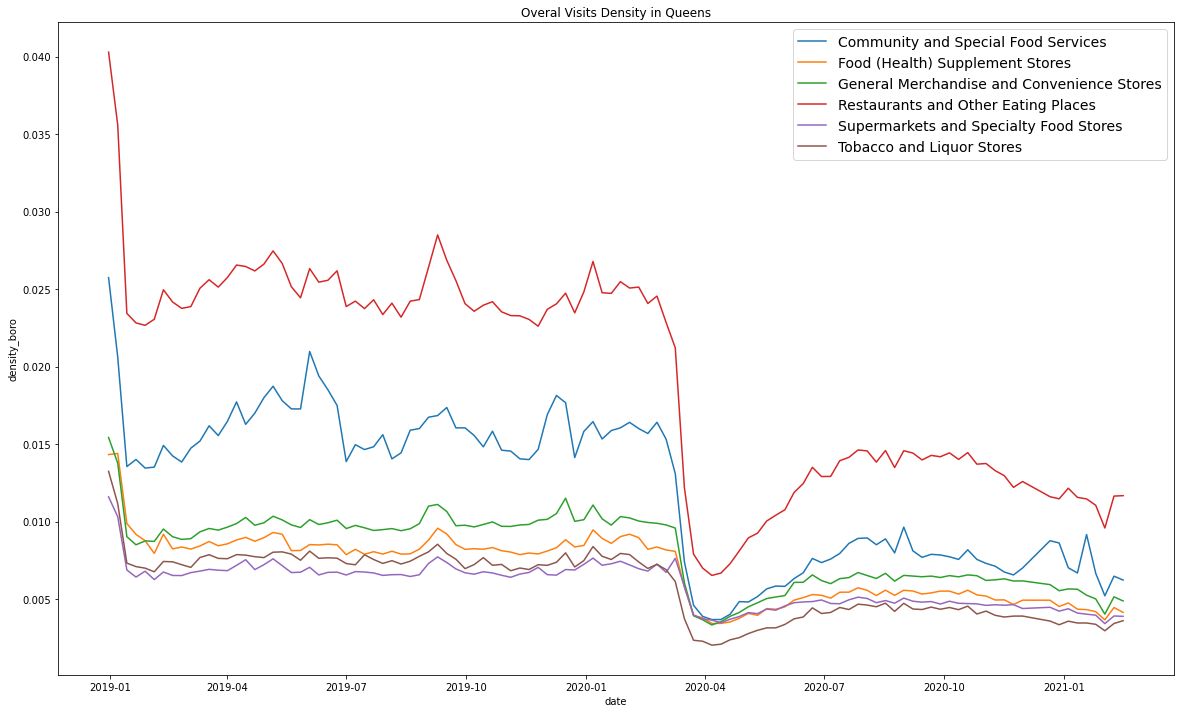

In [28]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Queens, x="date", y="density_boro", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Density in Queens")
plt.show()

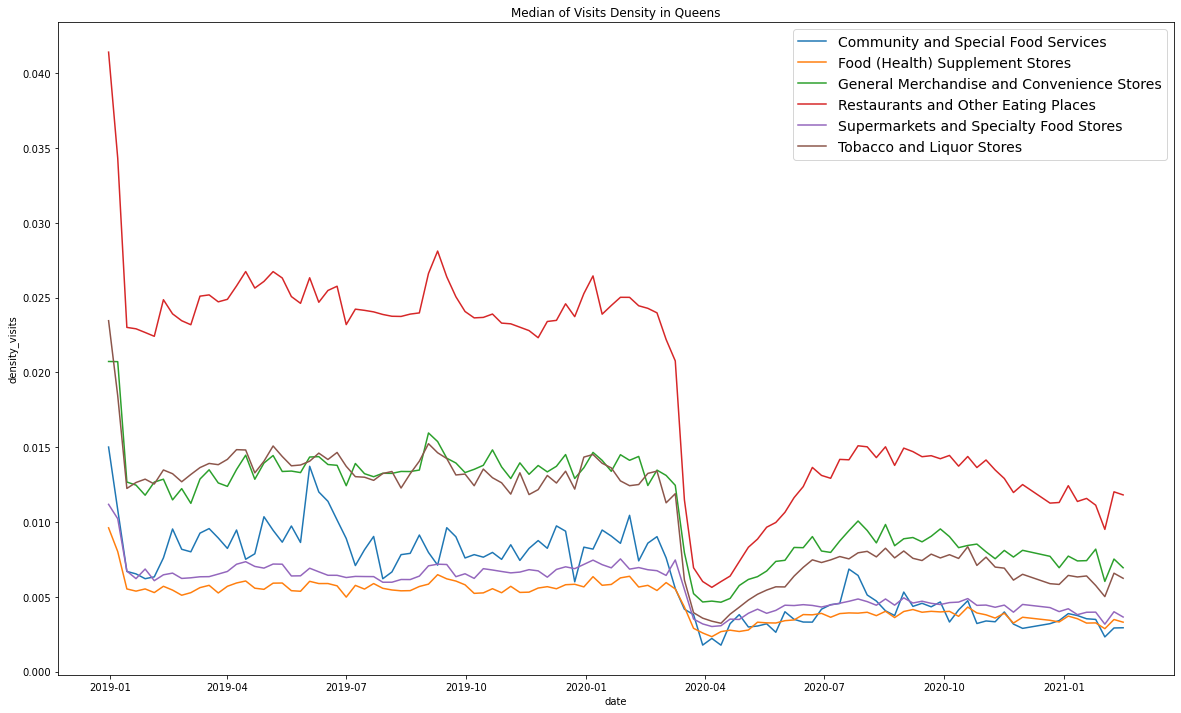

In [29]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Queens, x="date", y="density_visits", hue="category")
plt.legend(fontsize='14')
plt.title("Median of Visits Density in Queens")
plt.show()

### Staten Island

In [30]:
weekly_StatenIsland=weekly_sub[weekly_sub['borough']=='Staten Island']
weekly_ctg_StatenIsland = weekly_StatenIsland.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_ctg_StatenIsland['density_boro']=weekly_ctg_StatenIsland['raw_visit_counts']/weekly_ctg_Brooklyn['area_square_feet']

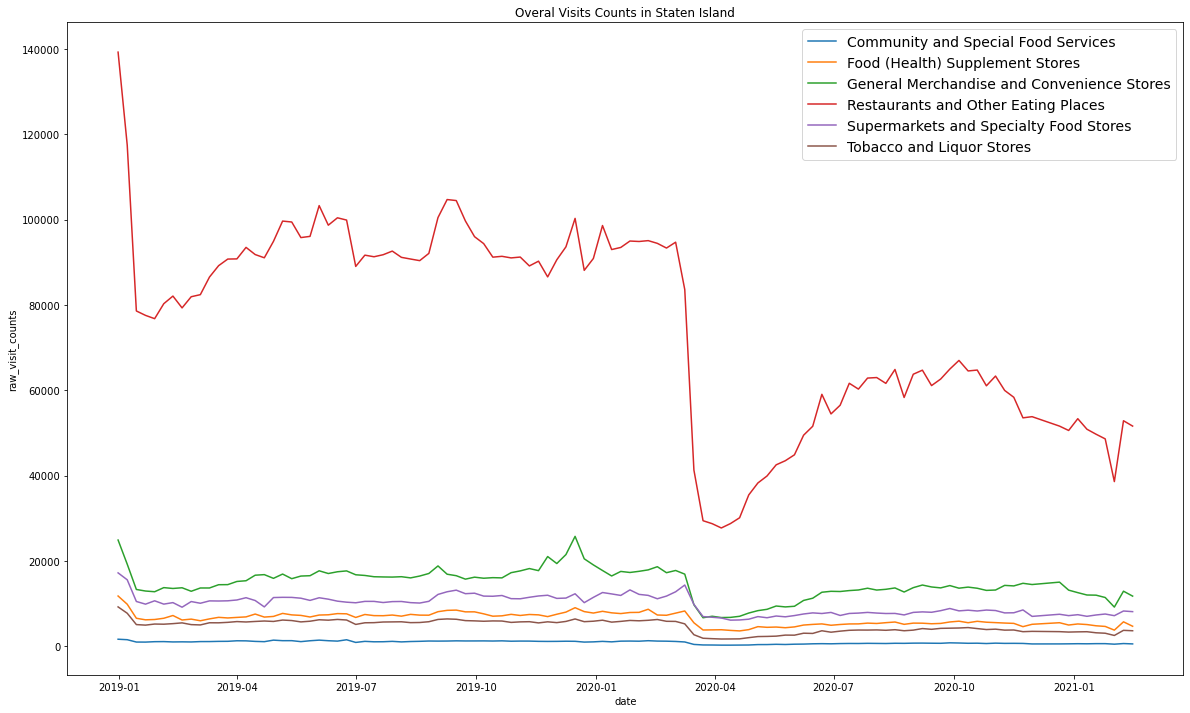

In [31]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_StatenIsland, x="date", y="raw_visit_counts", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts in Staten Island")
plt.show()

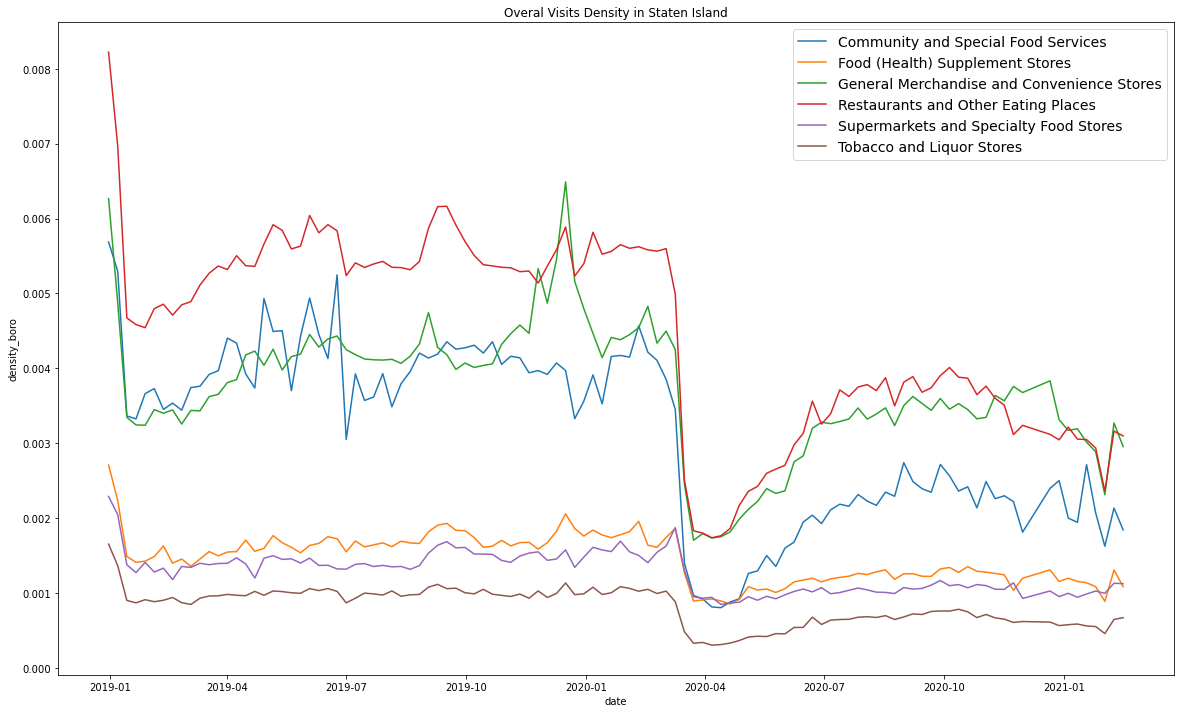

In [32]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_StatenIsland, x="date", y="density_boro", hue="category")
plt.legend(fontsize='14')
plt.title("Overal Visits Density in Staten Island")
plt.show()

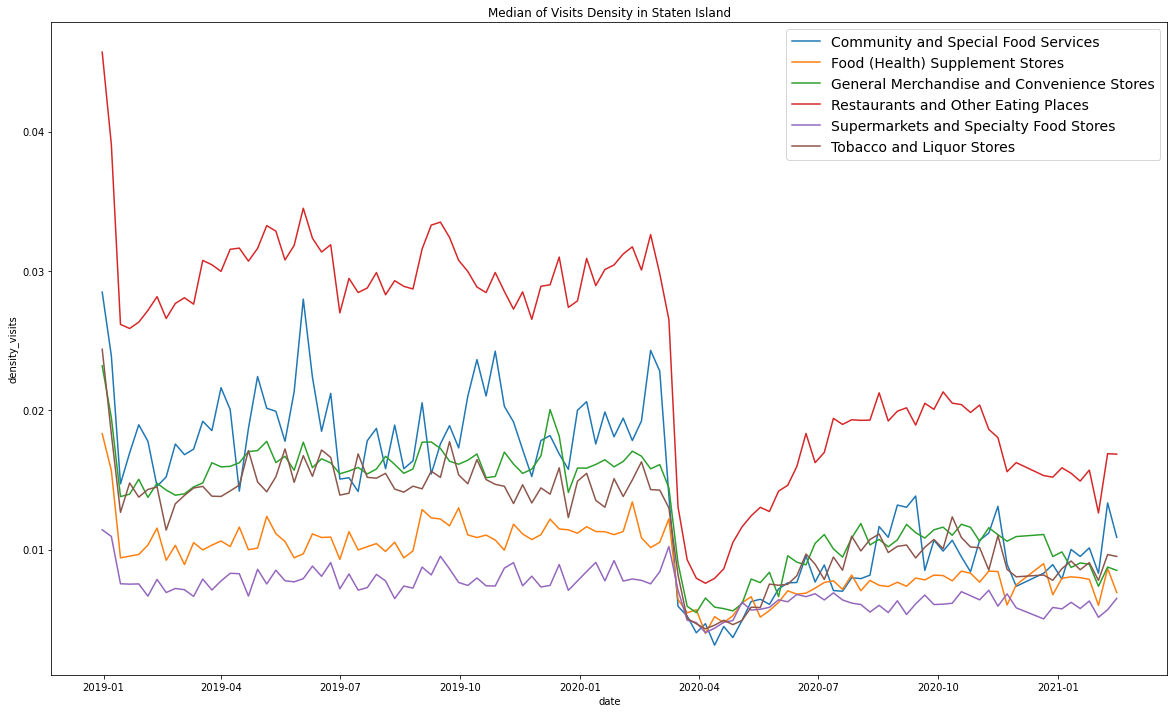

In [33]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_StatenIsland, x="date", y="density_visits", hue="category")
plt.legend(fontsize='14')
plt.title("Median of Visits Density in Staten Island")
plt.show()

In [34]:
list=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
weekly_sub=weekly_sub[(weekly_sub['borough']=='Manhattan')|(weekly_sub['borough']=='Brooklyn')|(weekly_sub['borough']=='Bronx')|(weekly_sub['borough']=='Queens')|(weekly_sub['borough']=='Staten Island')]

### Community and Special Food Services

In [35]:
weekly_community=weekly_sub[weekly_sub['category']=='Community and Special Food Services']
weekly_boro_community = weekly_community.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_community['density_boro']=weekly_boro_community['raw_visit_counts']/weekly_boro_community['area_square_feet']

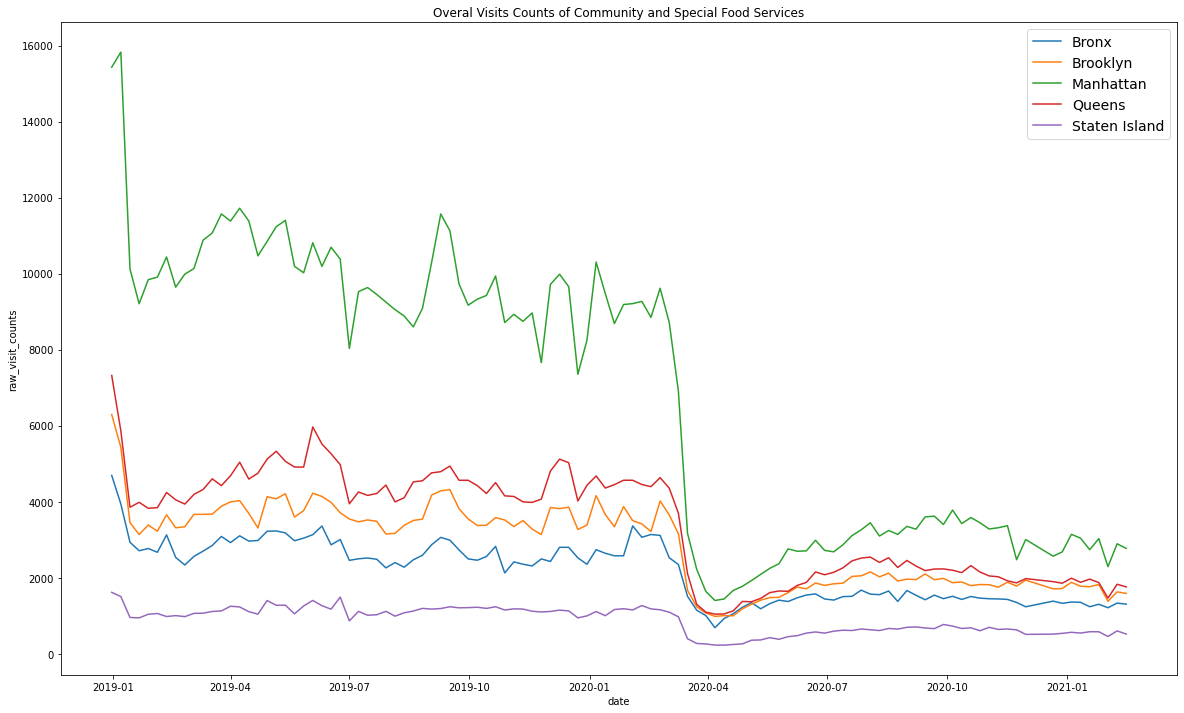

In [36]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_community, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of Community and Special Food Services")
plt.show()

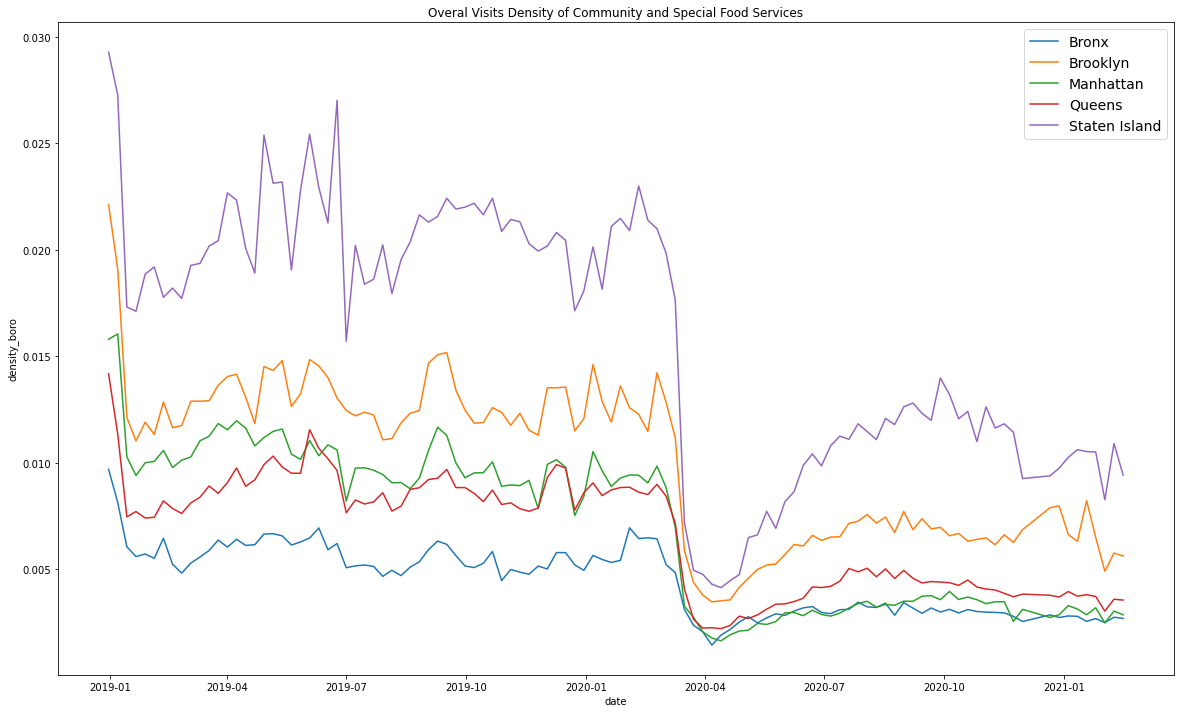

In [37]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_community, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of Community and Special Food Services")
plt.show()

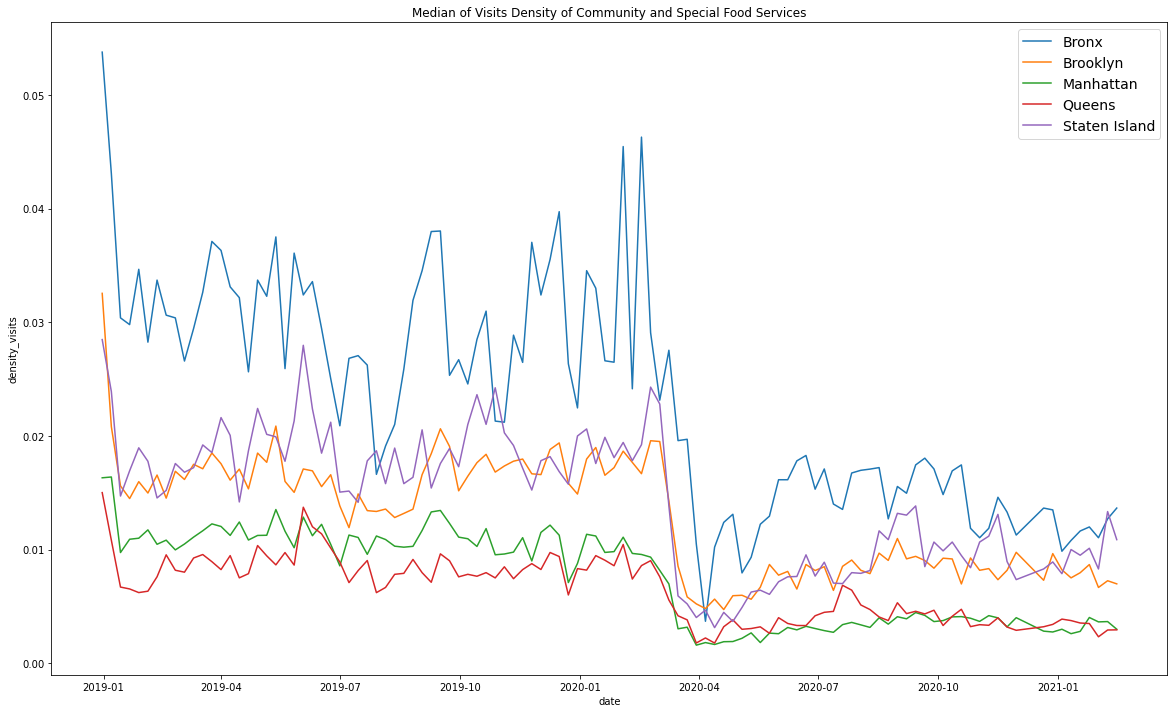

In [38]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_community, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of Community and Special Food Services")
plt.show()

In [39]:
weekly_sub['category'].unique()

array(['Supermarkets and Specialty Food Stores',
       'Restaurants and Other Eating Places',
       'General Merchandise and Convenience Stores',
       'Community and Special Food Services',
       'Food (Health) Supplement Stores', 'Tobacco and Liquor Stores'],
      dtype=object)

### Supermarkets and Specialty Food Stores

In [40]:
weekly_supermarket=weekly_sub[weekly_sub['category']=='Supermarkets and Specialty Food Stores']


weekly_boro_supermarket = weekly_supermarket.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_supermarket['density_boro']=weekly_boro_supermarket['raw_visit_counts']/weekly_boro_supermarket['area_square_feet']

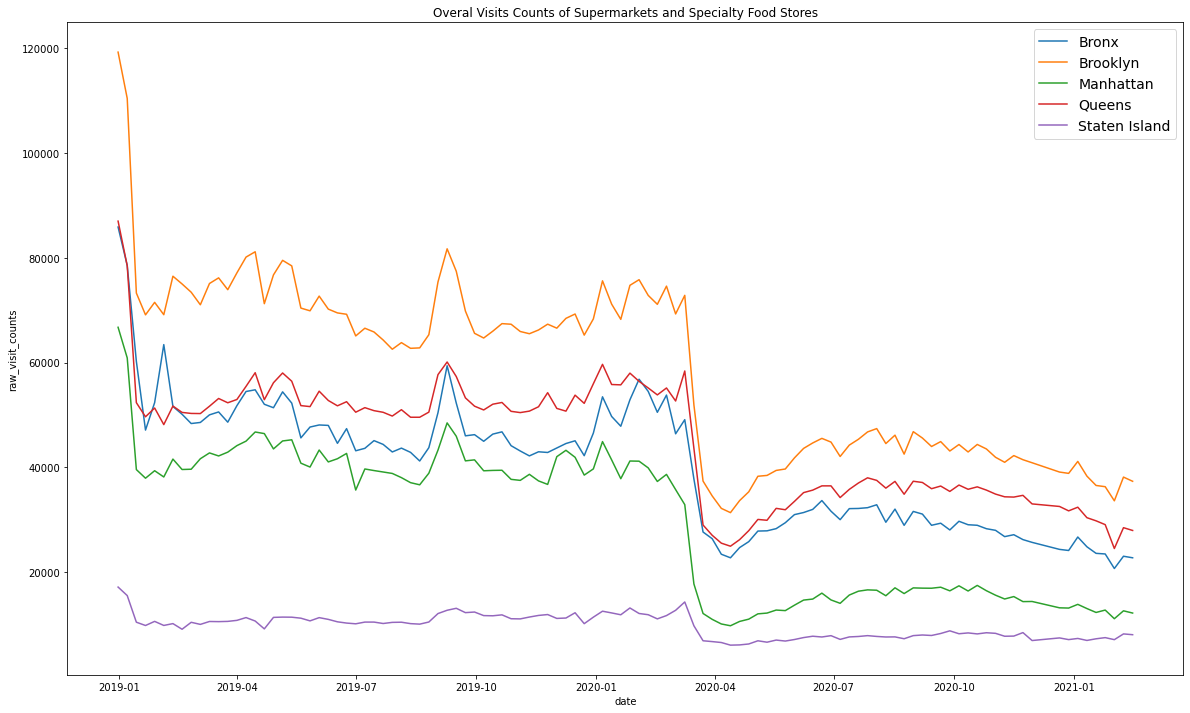

In [41]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_supermarket, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of Supermarkets and Specialty Food Stores")
plt.show()

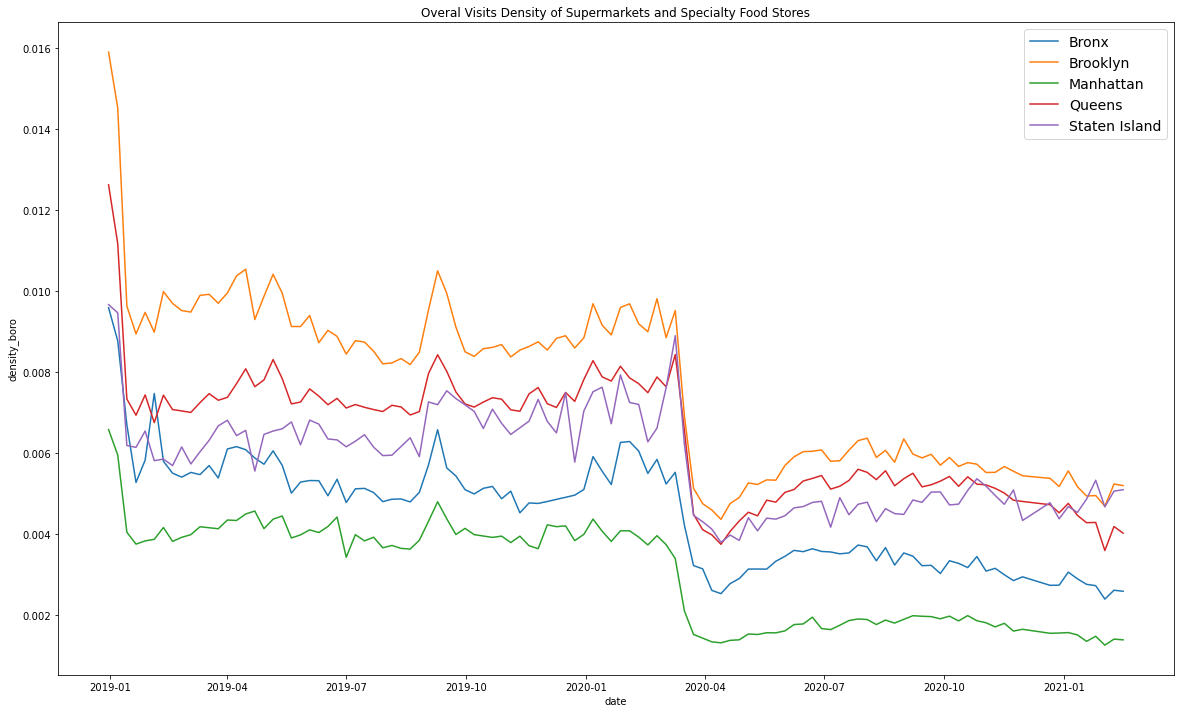

In [42]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_supermarket, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of Supermarkets and Specialty Food Stores")
plt.show()

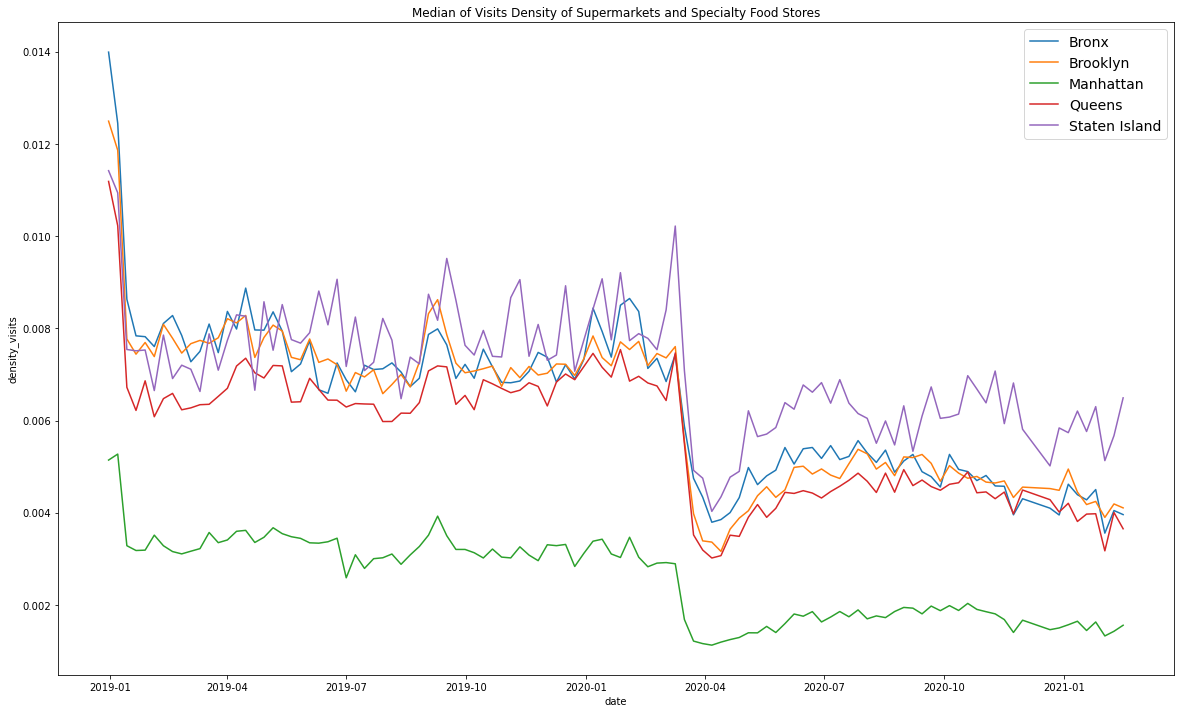

In [43]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_supermarket, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of Supermarkets and Specialty Food Stores")
plt.show()

### Restaurants and Other Eating Places

In [44]:
weekly_restaurant=weekly_sub[weekly_sub['category']=='Restaurants and Other Eating Places']
weekly_boro_restaurant = weekly_restaurant.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_restaurant['density_boro']=weekly_boro_restaurant['raw_visit_counts']/weekly_boro_restaurant['area_square_feet']

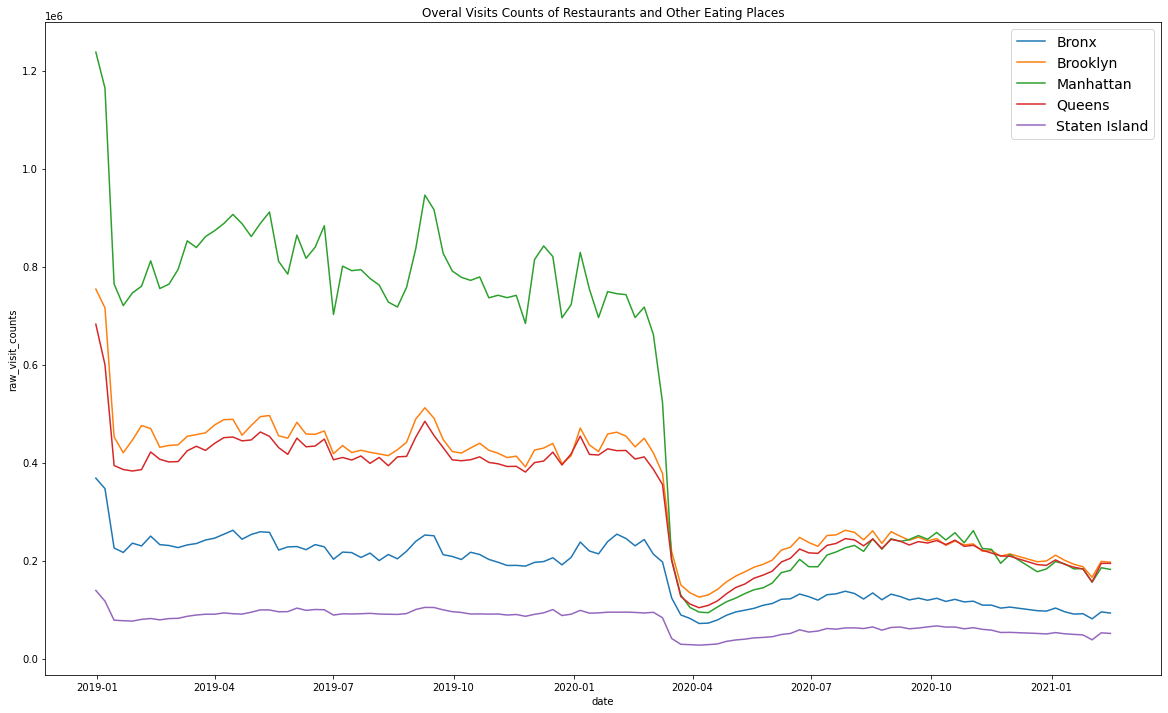

In [45]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of Restaurants and Other Eating Places")
plt.show()

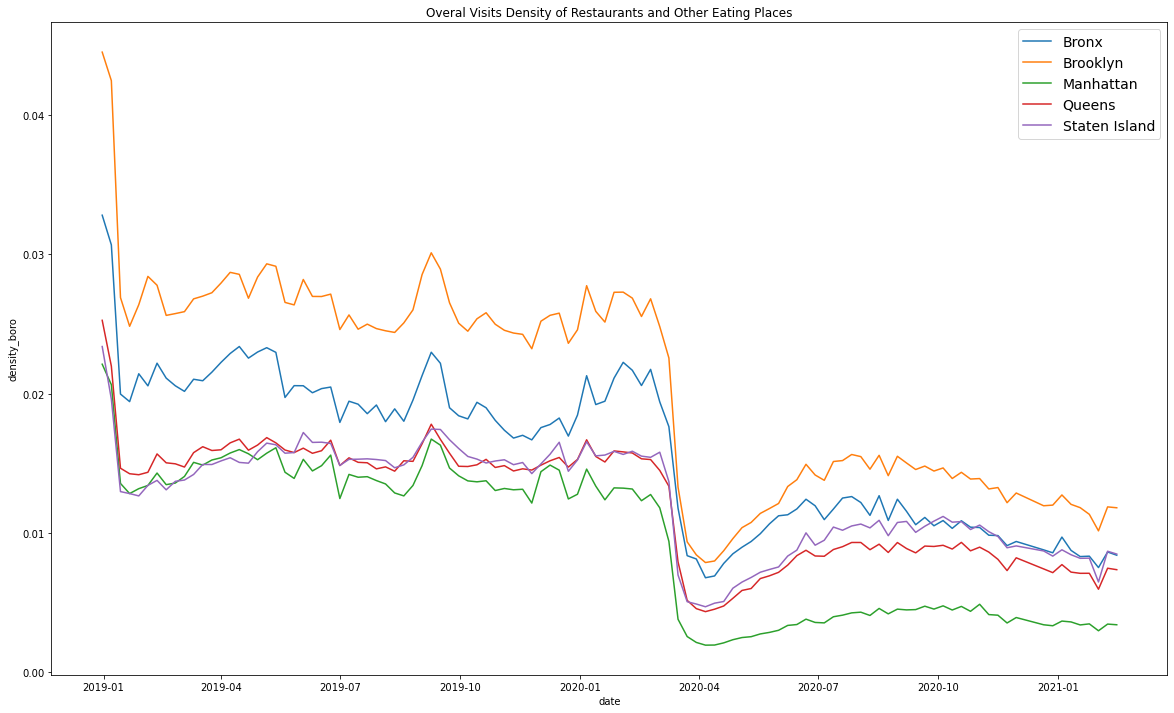

In [46]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of Restaurants and Other Eating Places")
plt.show()

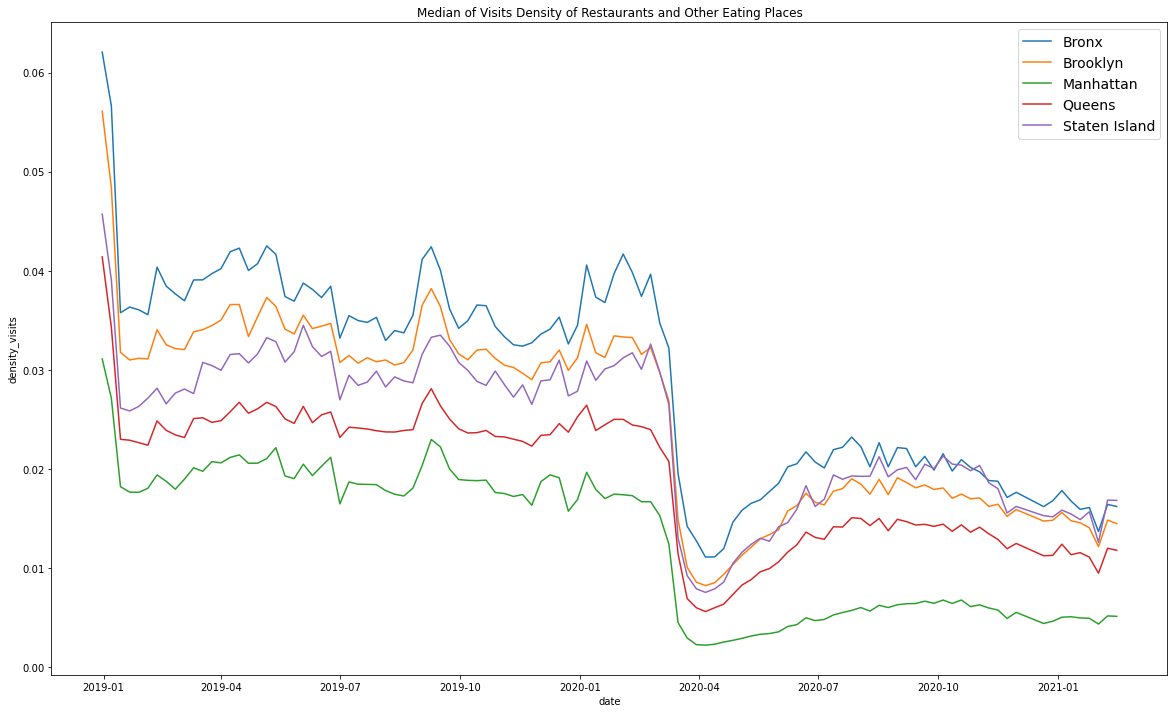

In [47]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of Restaurants and Other Eating Places")
plt.show()

### General Merchandise and Convenience Stores

In [48]:
weekly_general=weekly_sub[weekly_sub['category']=='General Merchandise and Convenience Stores']
weekly_boro_general = weekly_general.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_general['density_boro']=weekly_boro_general['raw_visit_counts']/weekly_boro_general['area_square_feet']

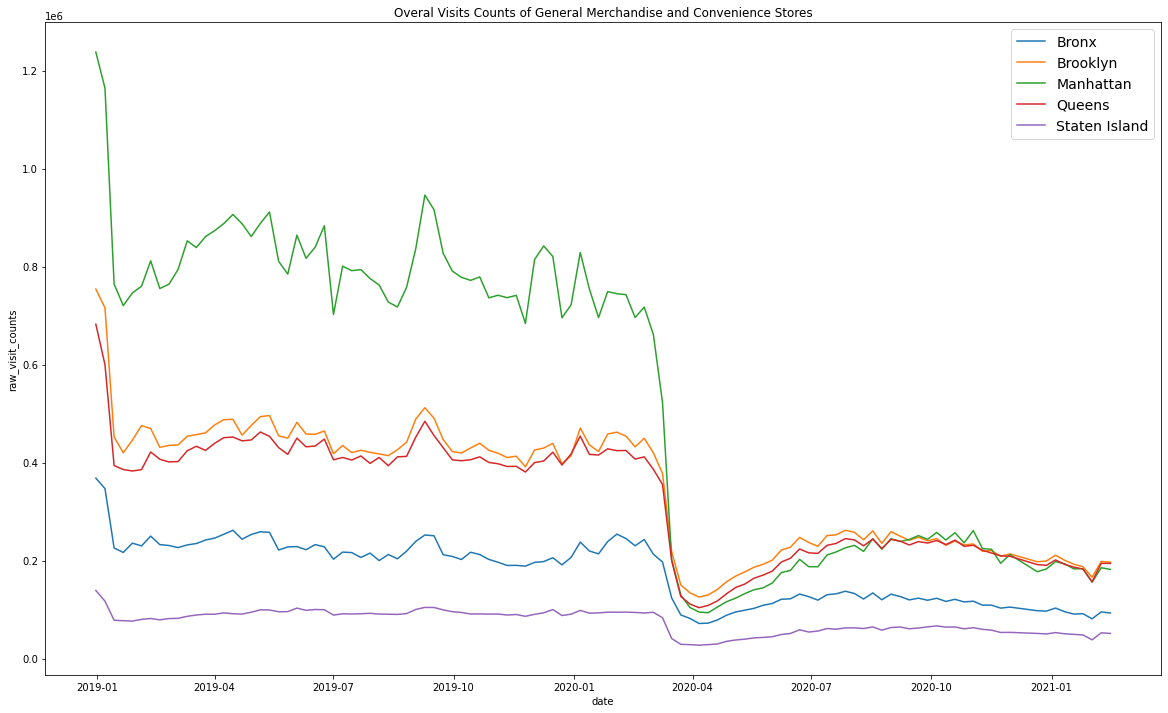

In [49]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of General Merchandise and Convenience Stores")
plt.show()

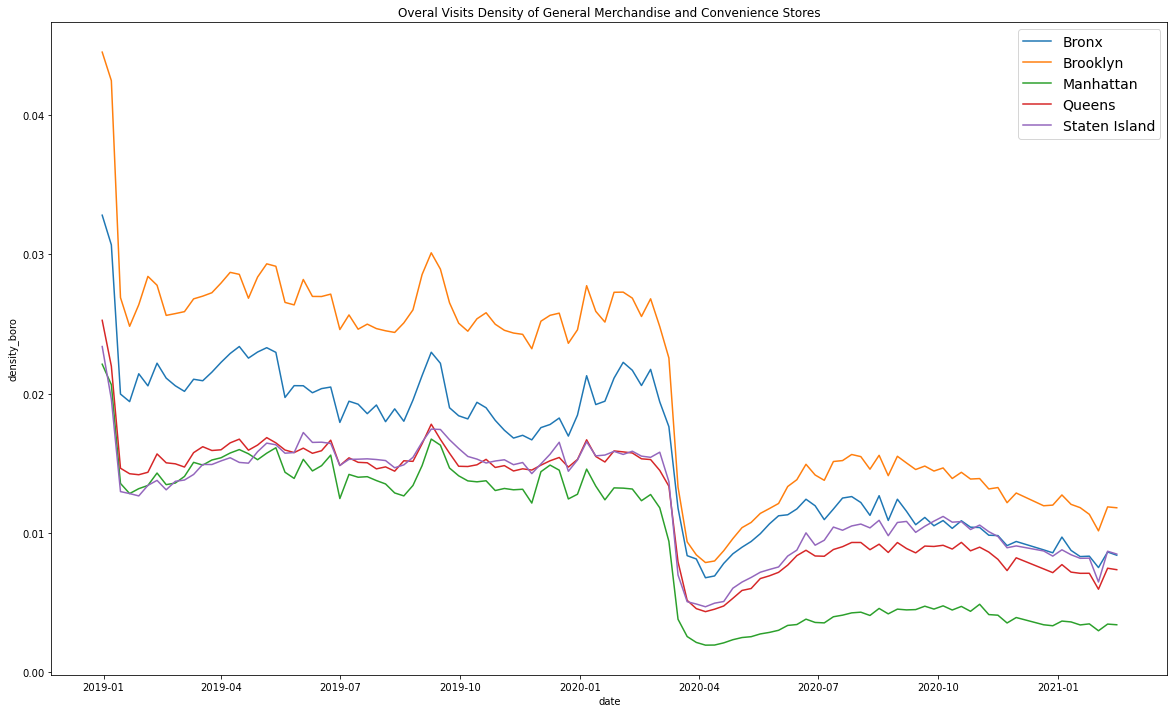

In [50]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of General Merchandise and Convenience Stores")
plt.show()

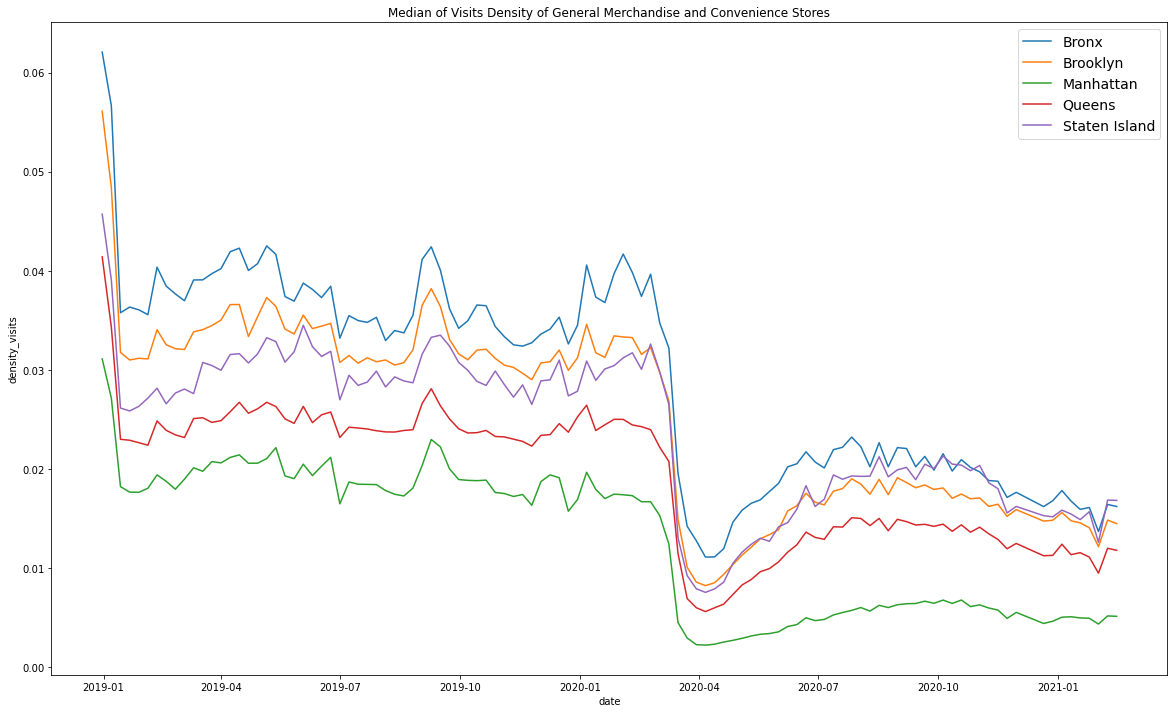

In [51]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of General Merchandise and Convenience Stores")
plt.show()

### Food (Health) Supplement Stores

In [52]:
weekly_food=weekly_sub[weekly_sub['category']=='Food (Health) Supplement Stores']
weekly_boro_food = weekly_food.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_food['density_boro']=weekly_boro_food['raw_visit_counts']/weekly_boro_food['area_square_feet']

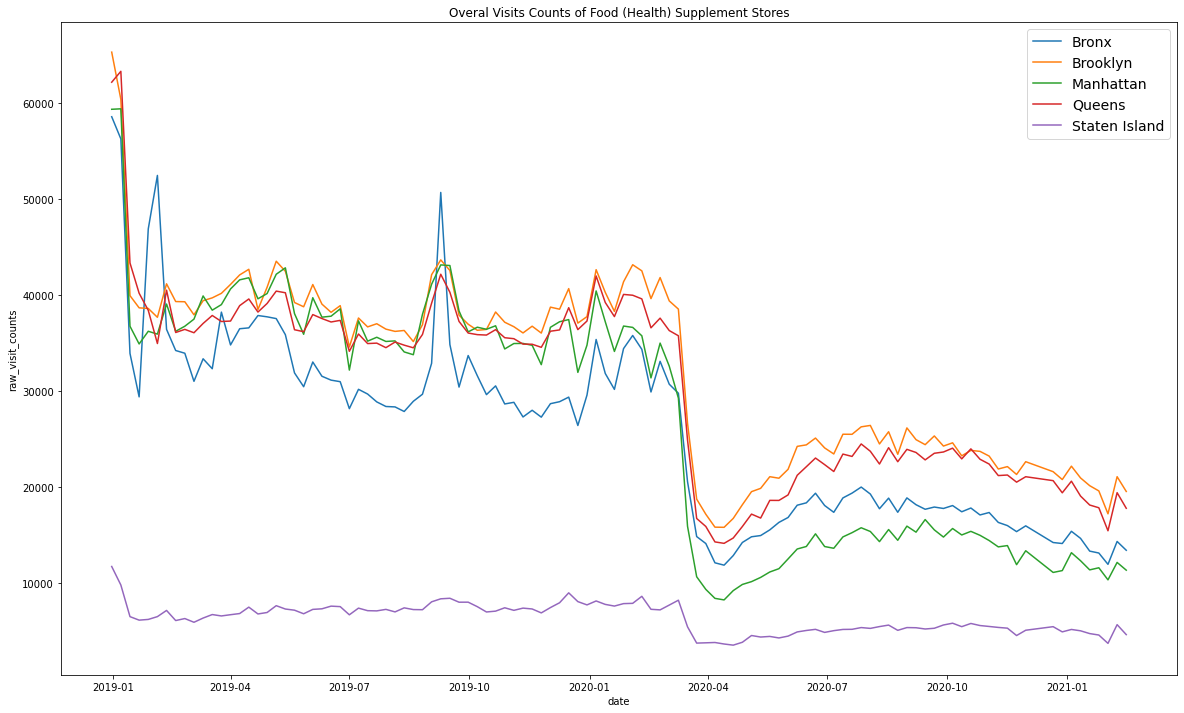

In [53]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_food, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of Food (Health) Supplement Stores")
plt.show()

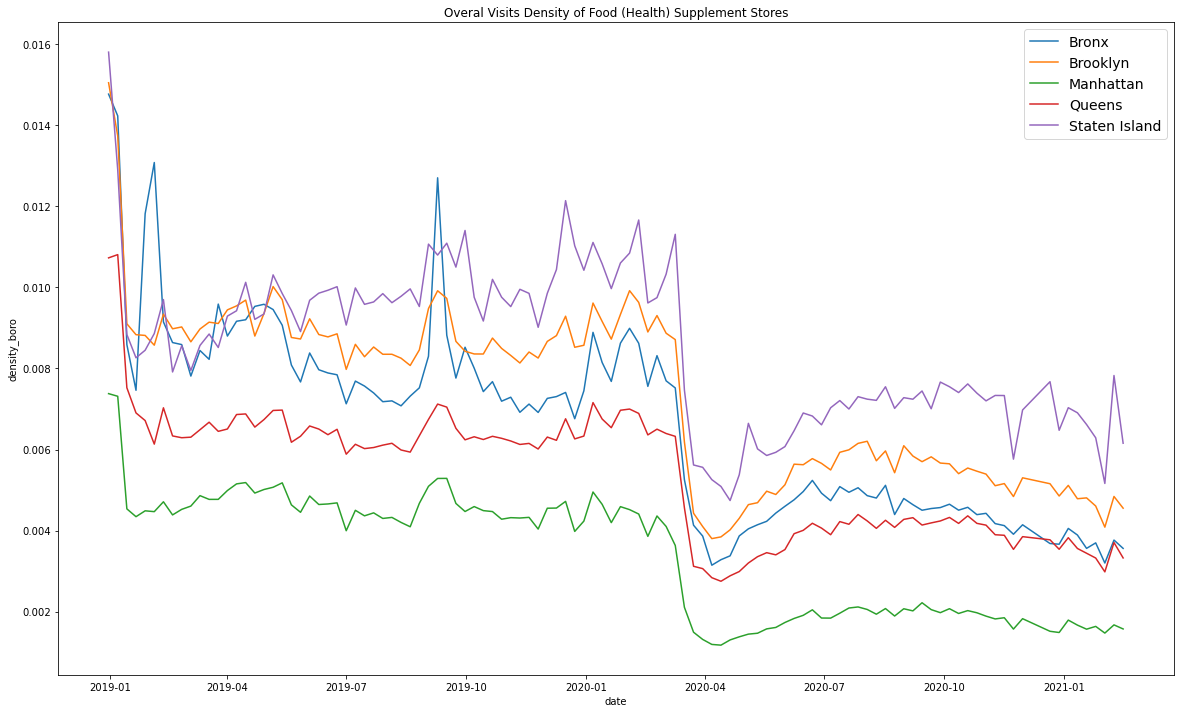

In [54]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_food, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of Food (Health) Supplement Stores")
plt.show()

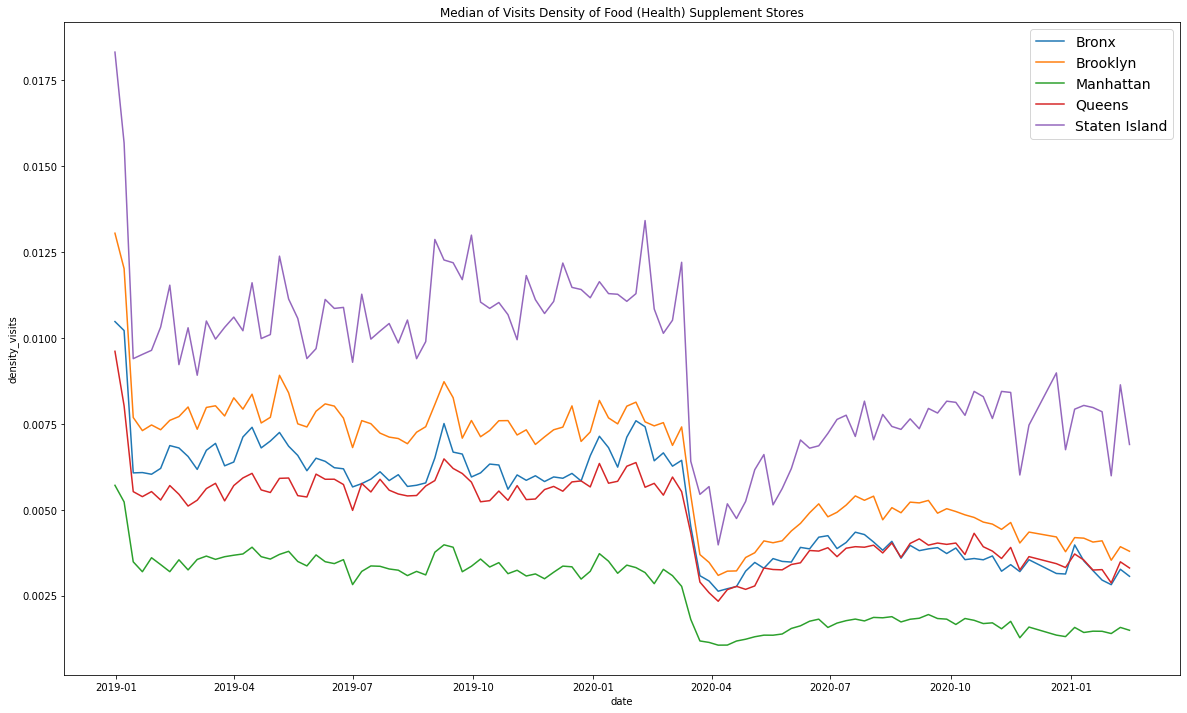

In [55]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_food, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of Food (Health) Supplement Stores")
plt.show()

### Tobacco and Liquor Stores

In [56]:
weekly_tobacco=weekly_sub[weekly_sub['category']=='Tobacco and Liquor Stores']
weekly_boro_tobacco = weekly_tobacco.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median'}) 
weekly_boro_tobacco['density_boro']=weekly_boro_tobacco['raw_visit_counts']/weekly_boro_tobacco['area_square_feet']

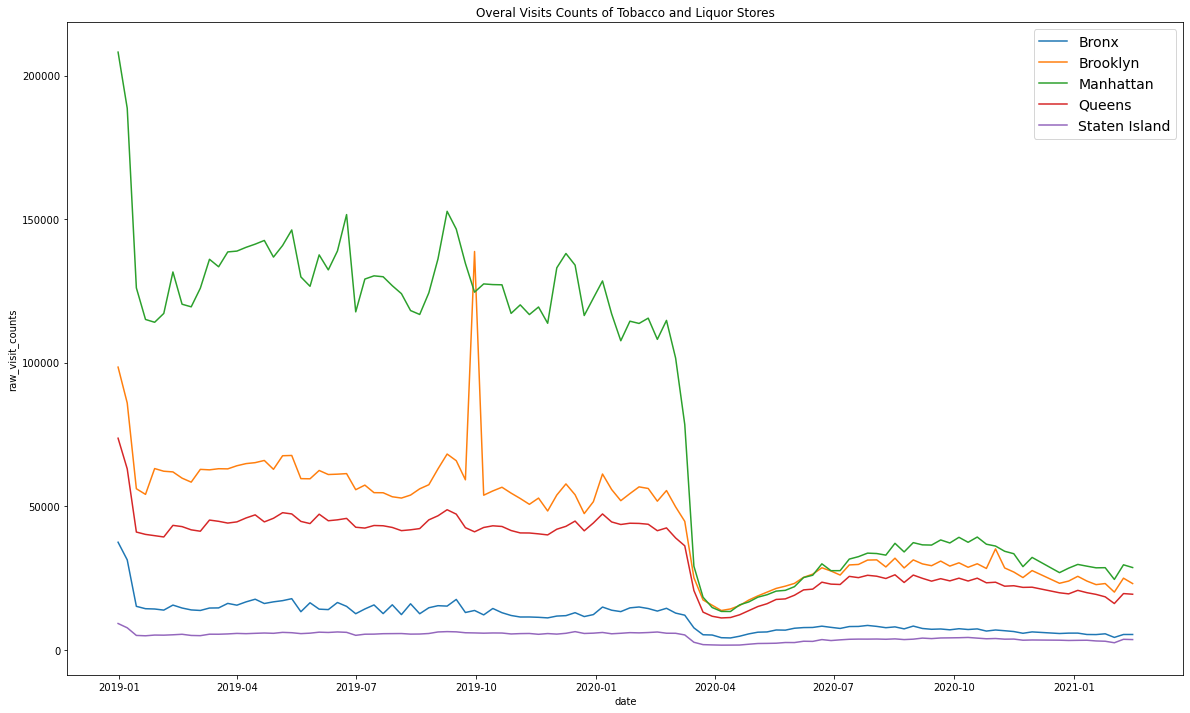

In [57]:
#1
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_tobacco, x="date", y="raw_visit_counts", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Counts of Tobacco and Liquor Stores")
plt.show()

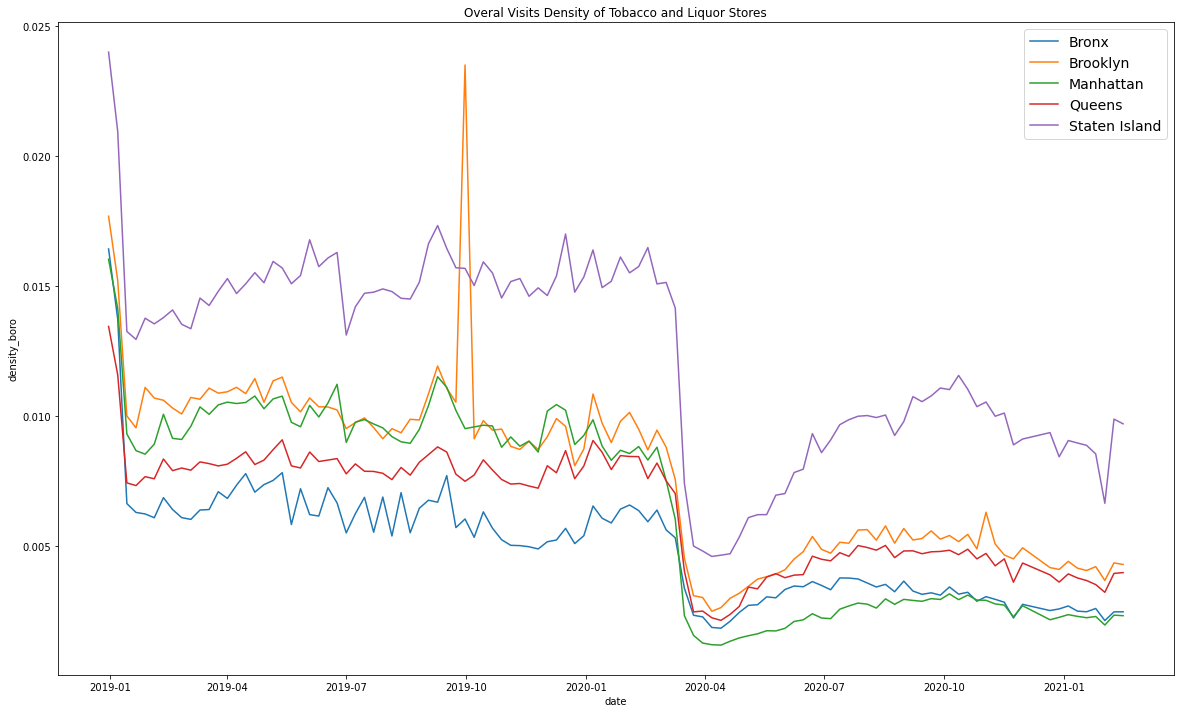

In [58]:
#2
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_tobacco, x="date", y="density_boro", hue="borough")
plt.legend(fontsize='14')
plt.title("Overal Visits Density of Tobacco and Liquor Stores")
plt.show()

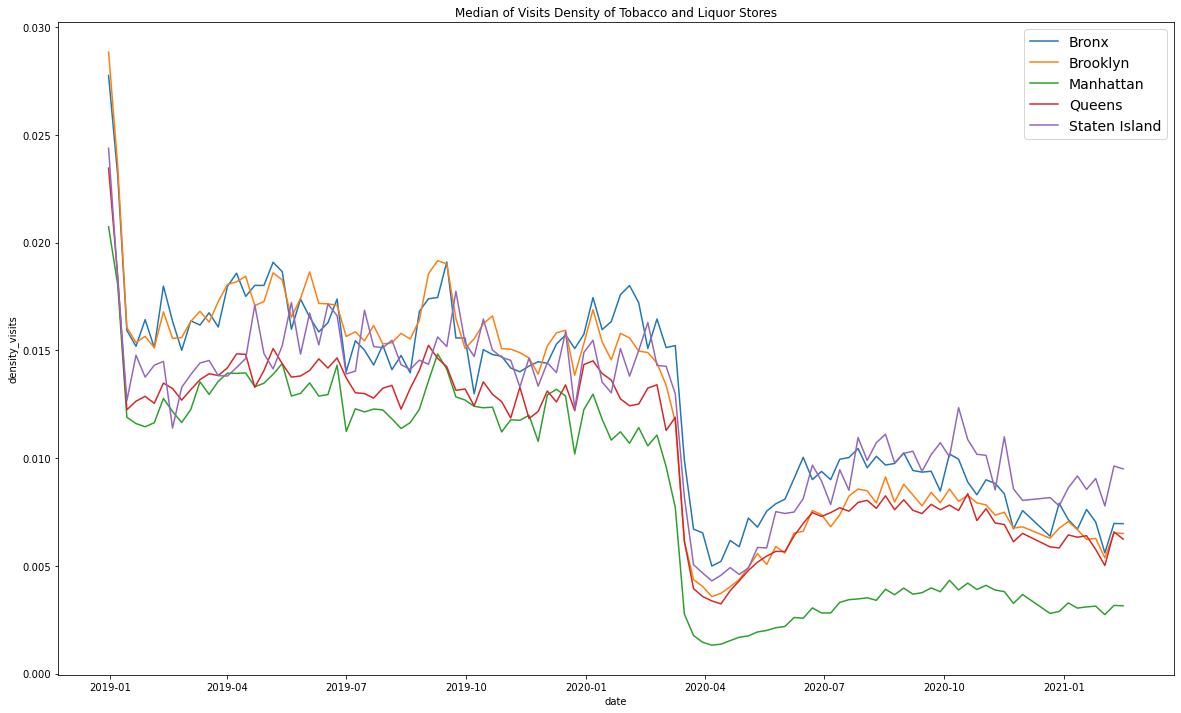

In [59]:
#3
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_tobacco, x="date", y="density_visits", hue="borough")
plt.legend(fontsize='14')
plt.title("Median of Visits Density of Tobacco and Liquor Stores")
plt.show()